In [50]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import pandas as pd, numpy as np, datetime as dt, itertools, matplotlib.pyplot as plt, seaborn as sns, finrl, random, time, ccxt, yfinance as yf

from ccxt import binance 
from data_fetcher import datafetcher
from finrl.config_tickers import DOW_30_TICKER
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split, YahooDownloader

plt.rcParams['figure.figsize'] = (18, 5)
plt.rcParams['figure.dpi'] = 300
sns.set_style('whitegrid')

%load_ext autoreload
%autoreload 2

%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# EDA need to add here. 
# ???

In [52]:
data = pd.read_csv("processed_daily_v2.csv")
data.head(10)

,date,tic,open,high,low,close,noOfTrans,volume,volumeWeight,weekday,...,open_sma_sdelta,open_sma_sbuzz,open_sma_sdispersion,open_sma_smean,close_sma_sscore,close_sma_svolume,close_sma_sdelta,close_sma_sbuzz,close_sma_sdispersion,close_sma_smean
0,2019-01-02,AAPL,38.7225,39.7125,38.5575,39.4800,249129.0,148159000.0,38.8871,2,...,-0.110,0.454,0.487,-3.457,-0.154,681.0,-0.210,0.792,0.439,-3.440
1,2019-01-03,AAPL,35.9950,36.4300,35.5000,35.5475,663513.0,365249000.0,35.8950,3,...,0.002,4.914,0.419,-6.359,-4.049,8786.0,0.015,3.263,0.409,-7.651
2,2019-01-04,AAPL,36.1325,37.1375,35.9500,37.0650,376070.0,234284000.0,36.7049,4,...,0.020,2.746,0.363,-8.173,-0.931,4299.0,-0.005,2.021,0.393,-7.671
3,2019-01-07,AAPL,37.1750,37.2075,36.4750,36.9825,348120.0,219111000.0,36.8423,0,...,-0.012,0.766,0.511,-7.485,0.432,493.0,0.003,0.758,0.529,-7.433
4,2019-01-08,AAPL,37.3900,37.9550,37.1300,37.6875,272197.0,164101000.0,37.5382,1,...,-0.002,1.320,0.474,-7.570,0.018,1328.0,0.058,0.636,0.408,-7.655
5,2019-01-09,AAPL,37.8225,38.6325,37.4075,38.3275,302931.0,180396000.0,38.2344,2,...,0.012,0.701,0.384,-7.413,0.222,1811.0,-0.055,0.776,0.367,-7.377
6,2019-01-10,AAPL,38.1250,38.4925,37.7150,38.4500,202210.0,143123000.0,38.1879,3,...,0.007,0.686,0.384,-7.470,-0.073,1246.0,0.031,0.597,0.422,-7.449
7,2019-01-11,AAPL,38.2200,38.4250,37.8775,38.0725,174588.0,108083000.0,38.0991,4,...,0.003,0.556,0.453,-7.245,0.500,1048.0,0.024,0.577,0.509,-7.067
8,2019-01-14,AAPL,37.7125,37.8175,37.3050,37.5000,201651.0,129757000.0,37.5041,0,...,0.000,0.693,0.607,-6.523,0.236,480.0,-0.070,0.675,0.577,-6.537
9,2019-01-15,AAPL,37.5675,38.3475,37.5125,38.2675,178869.0,114841000.0,38.0894,1,...,-0.004,0.825,0.471,-6.516,0.332,836.0,0.041,0.579,0.465,-6.435


In [53]:
data.isnull().sum()

date                     0
tic                      0
open                     0
high                     0
low                      0
close                    0
noOfTrans                0
volume                   0
volumeWeight             0
weekday                  0
day                      0
year                     0
month                    0
open_sma_sscore          0
open_sma_svolume         0
open_sma_sdelta          0
open_sma_sbuzz           0
open_sma_sdispersion     0
open_sma_smean           0
close_sma_sscore         0
close_sma_svolume        0
close_sma_sdelta         0
close_sma_sbuzz          0
close_sma_sdispersion    0
close_sma_smean          0
dtype: int64

In [54]:
data.describe()

,open,high,low,close,noOfTrans,volume,volumeWeight,weekday,day,year,...,open_sma_sdelta,open_sma_sbuzz,open_sma_sdispersion,open_sma_smean,close_sma_sscore,close_sma_svolume,close_sma_sdelta,close_sma_sbuzz,close_sma_sdispersion,close_sma_smean
count,128189.000000,128189.000000,128189.000000,128189.000000,1.281890e+05,1.281890e+05,128189.000000,128189.000000,128189.000000,128189.000000,...,128189.000000,128189.000000,128189.000000,128189.000000,128189.000000,128189.000000,128189.000000,128189.000000,128189.000000,128189.000000
mean,194.779521,197.293797,192.236415,194.822217,7.090185e+04,1.320091e+07,194.804138,2.025369,15.732341,2021.000390,...,-0.008461,1.285567,0.768441,0.188972,0.062901,99.079235,0.004278,1.172685,0.767158,0.191891
std,260.355723,263.869917,256.813706,260.367646,1.241939e+05,5.305945e+07,260.382133,1.397035,8.763977,1.412392,...,0.202783,1.008414,0.186342,0.863185,1.375924,477.217205,0.232063,0.736439,0.182946,0.873190
min,3.266000,3.379000,3.192300,3.199800,4.970000e+02,2.015100e+04,3.237800,0.000000,0.000000,2019.000000,...,-5.499000,0.207000,0.043000,-25.853000,-4.208000,1.000000,-6.515000,0.267000,0.053000,-26.158000
25%,64.020000,64.800000,63.240000,64.020000,2.321200e+04,1.632450e+06,64.033800,1.000000,8.000000,2020.000000,...,-0.012000,0.591000,0.632000,0.026000,-0.571000,6.000000,-0.017000,0.580000,0.635000,0.027000
50%,132.880000,134.340000,131.280000,132.890000,4.012600e+04,3.541960e+06,132.865000,2.000000,16.000000,2021.000000,...,-0.004000,0.877000,0.769000,0.075000,-0.006000,15.000000,-0.003000,0.793000,0.767000,0.077000
75%,225.520000,228.560000,222.630000,225.480000,7.268900e+04,8.115930e+06,225.565000,3.000000,23.000000,2022.000000,...,0.001000,1.715000,1.000000,0.196000,0.780000,39.000000,0.007000,1.661000,0.944000,0.199000
max,3580.620000,3580.620000,3540.180000,3566.650000,2.966980e+06,2.511530e+09,3560.020000,4.000000,31.000000,2023.000000,...,3.647000,17.104000,1.000000,18.654000,4.241000,26498.000000,6.335000,8.040000,1.000000,18.487000


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128189 entries, 0 to 128188
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   128189 non-null  object 
 1   tic                    128189 non-null  object 
 2   open                   128189 non-null  float64
 3   high                   128189 non-null  float64
 4   low                    128189 non-null  float64
 5   close                  128189 non-null  float64
 6   noOfTrans              128189 non-null  float64
 7   volume                 128189 non-null  float64
 8   volumeWeight           128189 non-null  float64
 9   weekday                128189 non-null  int64  
 10  day                    128189 non-null  int64  
 11  year                   128189 non-null  int64  
 12  month                  128189 non-null  int64  
 13  open_sma_sscore        128189 non-null  float64
 14  open_sma_svolume       128189 non-nu

In [56]:
data.drop(columns='day', inplace=True)

In [57]:
data.rename(columns={'weekday':'day'}, inplace=True)

In [58]:
# selecting the user define features for the model 
USER_DEFINED_FEATURES = data.columns.tolist()[13:]
USER_DEFINED_FEATURES.extend(["noOfTrans", "volume", "volumeWeight"])
USER_DEFINED_FEATURES

['open_sma_svolume',
 'open_sma_sdelta',
 'open_sma_sbuzz',
 'open_sma_sdispersion',
 'open_sma_smean',
 'close_sma_sscore',
 'close_sma_svolume',
 'close_sma_sdelta',
 'close_sma_sbuzz',
 'close_sma_sdispersion',
 'close_sma_smean',
 'noOfTrans',
 'volume',
 'volumeWeight']

In [59]:
# feture engineering 

fe = FeatureEngineer(use_technical_indicator=True, tech_indicator_list=INDICATORS, use_vix=True, use_turbulence=True, user_defined_feature=False)

processed = fe.preprocess_data(data)

processed.head()

Successfully added technical indicators


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (1257, 8)
Successfully added vix
Successfully added turbulence index


,date,tic,open,high,low,close,noOfTrans,volume,volumeWeight,day,...,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2019-01-02,AAPL,38.7225,39.7125,38.5575,39.48,249129.0,148159000.0,38.8871,2,...,0.0,43.075145,31.952355,0.0,-66.666667,100.0,39.48,39.48,23.219999,0.0
1,2019-01-02,ADBE,219.9100,226.1700,219.0000,224.57,33560.0,2784110.0,223.6040,2,...,0.0,43.075145,31.952355,0.0,-66.666667,100.0,224.57,224.57,23.219999,0.0
2,2019-01-02,ADI,82.9900,84.3500,80.5500,80.73,37676.0,4376620.0,81.7822,2,...,0.0,43.075145,31.952355,0.0,-66.666667,100.0,80.73,80.73,23.219999,0.0
3,2019-01-02,ADP,129.1600,130.7800,128.6100,130.14,20628.0,2190100.0,129.8590,2,...,0.0,43.075145,31.952355,0.0,-66.666667,100.0,130.14,130.14,23.219999,0.0
4,2019-01-02,ADSK,125.3900,129.6400,124.6500,128.96,15415.0,1517460.0,128.2240,2,...,0.0,43.075145,31.952355,0.0,-66.666667,100.0,128.96,128.96,23.219999,0.0


In [60]:
processed.columns

Index(['date', 'tic', 'open', 'high', 'low', 'close', 'noOfTrans', 'volume',
       'volumeWeight', 'day', 'year', 'month', 'open_sma_sscore',
       'open_sma_svolume', 'open_sma_sdelta', 'open_sma_sbuzz',
       'open_sma_sdispersion', 'open_sma_smean', 'close_sma_sscore',
       'close_sma_svolume', 'close_sma_sdelta', 'close_sma_sbuzz',
       'close_sma_sdispersion', 'close_sma_smean', 'macd', 'boll_ub',
       'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma',
       'vix', 'turbulence'],
      dtype='object')

In [61]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125700 entries, 0 to 125699
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   125700 non-null  object 
 1   tic                    125700 non-null  object 
 2   open                   125700 non-null  float64
 3   high                   125700 non-null  float64
 4   low                    125700 non-null  float64
 5   close                  125700 non-null  float64
 6   noOfTrans              125700 non-null  float64
 7   volume                 125700 non-null  float64
 8   volumeWeight           125700 non-null  float64
 9   day                    125700 non-null  int64  
 10  year                   125700 non-null  int64  
 11  month                  125700 non-null  int64  
 12  open_sma_sscore        125700 non-null  float64
 13  open_sma_svolume       125700 non-null  float64
 14  open_sma_sdelta        125700 non-nu

In [62]:
# split data into train and test

train = data_split(processed, '2019-01-01', '2023-06-31')
test = data_split(processed, '2023-07-01', '2023-12-31')


In [63]:
test

,date,tic,open,high,low,close,noOfTrans,volume,volumeWeight,day,...,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-07-03,AAPL,193.78,193.8800,191.76,192.4600,500175.0,31458200.0,192.6620,0,...,4.065128,193.518843,177.161157,68.474774,149.657549,66.626390,182.266333,175.346083,13.57,83.956597
0,2023-07-03,ADBE,486.39,486.6100,479.84,485.2100,48087.0,1491010.0,483.7300,0,...,20.734086,516.271431,432.144569,65.728971,61.807865,44.767335,451.071333,406.986500,13.57,83.956597
0,2023-07-03,ADI,193.98,196.5500,192.27,194.3300,24376.0,1367580.0,193.9620,0,...,2.406944,196.749900,178.561100,56.890130,116.084148,18.738547,184.825667,184.921000,13.57,83.956597
0,2023-07-03,ADP,218.22,219.2300,216.25,218.7300,19105.0,848290.0,218.5050,0,...,0.581839,222.771112,213.022888,51.384143,48.501262,10.693020,216.352667,215.779833,13.57,83.956597
0,2023-07-03,ADSK,203.00,205.1900,202.11,203.7000,21182.0,818877.0,203.2490,0,...,0.733466,218.487666,196.479334,50.350505,-19.286669,12.678739,205.113667,200.127333,13.57,83.956597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,2023-12-28,VRTX,411.26,412.5700,409.00,409.2700,24959.0,735650.0,410.1110,3,...,13.225839,435.562412,328.795588,64.053243,108.198524,51.400944,371.751333,369.555667,12.47,32.992117
124,2023-12-28,VZ,37.18,37.7200,37.15,37.4900,82977.0,14931700.0,37.5201,3,...,0.248342,38.795585,36.775415,56.822280,-7.086509,11.843748,37.514667,35.460000,12.47,32.992117
124,2023-12-28,WDAY,274.14,277.0000,272.71,276.0800,22625.0,839286.0,275.9590,3,...,8.331123,278.541095,266.943905,66.077485,61.369896,52.398793,261.039667,238.380500,12.47,32.992117
124,2023-12-28,WMT,52.59,52.7767,52.50,52.5233,81975.0,16776100.0,52.5901,3,...,-0.115723,52.812537,50.070803,50.021832,84.639562,13.333716,51.789447,52.907782,12.47,32.992117


In [64]:
from finrl.config import INDICATORS, USER_DEFINED_FEATURES

In [65]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + len(USER_DEFINED_FEATURES)*stock_dimension
print(state_space)

2401


In [66]:
# Env initialization for multi-stock trading

env_kwargs = {
    "hmax": 50,
    "initial_amount": 1e6,
    "state_space": state_space,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "buy_cost_pct":[1e-3]*stock_dimension,
    "sell_cost_pct":[1e-3]*stock_dimension,
    "stock_dim": stock_dimension, 
    "num_stock_shares": [0]*stock_dimension,
    "tech_indicator_list": INDICATORS + USER_DEFINED_FEATURES, 
    "make_plots": True, 
    "model_name": "SAC"
}

e_train_gym = StockTradingEnv(df=train, **env_kwargs)

In [67]:
print(type(e_train_gym))

<class 'finrl.meta.env_stock_trading.env_stocktrading.StockTradingEnv'>


In [68]:
gym_env, _ = e_train_gym.get_sb_env()
print(gym_env)

In [69]:
gym_env._obs_from_buf()

array([[1.00000e+06, 3.94800e+01, 2.24570e+02, ..., 1.58620e+02,
        3.10249e+01, 4.82969e+01]], dtype=float32)

##### Models"

- DDPG 
    - Policy (Strategy - when to buy, what to buy at what price)
    - Target Actor(action) and Critics(Q-values) 
    - D-Qlearning -- Classical method
    - Off -Policy (RL type)  -- Historical data
    - Conitunes states (Action and Market)  ---- Tarding continues (buy(55, 57), sell, hold )
    - Buffer size
- SAC 
    - Upgraded version
    - Actor, Critics 
    - To stable leanring 



In [70]:
# Agent initialization
agent  = DRLAgent(env = gym_env)

# model_kwargs = {
#     'learning_rate': 0.0003,  # Learning rate for both policy and value networks
#     'buffer_size': 1000000,  # Size of the replay buffer
#     'learning_starts': 10000,  # Number of steps before training starts
#     'batch_size': 256,  # Batch size for training
#     'tau': 0.005,  # Soft update coefficient for target network updates
#     'gamma': 0.99,  # Discount factor
#     'train_freq': 1,  # Frequency of training updates
#     'gradient_steps': 1,  # Number of gradient steps per update
#     'ent_coef': 'auto',  # Entropy coefficient (can be 'auto' or a fixed value)
#     'target_update_interval': 1,  # Interval for updating the target network
#     'use_sde': False,  # Whether to use State Dependent Exploration
#     'sde_sample_freq': -1,  # Frequency of sampling noise for SDE
#     'verbose': 1  # Verbosity level (0: no output, 1: info, 2: debug)
# }

# Example of what DRLAgent.get_model might expect
agent_kwargs = {
    'learning_rate': 0.001,  # Reduce learning rate for more stable learning
    'buffer_size': 50000,    # Increase buffer size to learn from more experiences
    'learning_starts': 1000, # Increase steps before training starts to gather more initial experience
    'batch_size': 256,       # Maintain the batch size
    'tau': 0.01,             # Lower tau for smoother target network updates
    'gamma': 0.99,           # Increase gamma to place more value on future rewards
    'train_freq': 1,         # Maintain the training frequency
    'gradient_steps': 1,     # Maintain the number of gradient steps per update
    'ent_coef': 'auto',      # Keep entropy coefficient auto for balancing exploration and exploitation
    'target_update_interval': 1,  # Maintain frequent target network updates
    'use_sde': True,         # Enable State Dependent Exploration
    'sde_sample_freq': -1,   # Maintain sampling noise at the start of each episode
    # 'verbose': 0             # Enable verbosity to monitor training progress
}

# Example initialization assuming agent_kwargs needs to be passed differently
model = agent.get_model('sac', model_kwargs=agent_kwargs)


# model = agent.get_model('sac', **model_kwargs)

# model = agent.get_model('sac')

# Furthuer  need to work in 


{'learning_rate': 0.001, 'buffer_size': 50000, 'learning_starts': 1000, 'batch_size': 256, 'tau': 0.01, 'gamma': 0.99, 'train_freq': 1, 'gradient_steps': 1, 'ent_coef': 'auto', 'target_update_interval': 1, 'use_sde': True, 'sde_sample_freq': -1}
Using cuda device


d:\RL-Project\Py310-venv\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 0.98GB > 0.52GB
  warnings.warn(


In [71]:
len(train)

113200

In [72]:
trained_model = agent.train_model(model=model, tb_log_name='sac', total_timesteps=100000)

Episode: 2
Episode: 3
Episode: 4
Episode: 5
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 52        |
|    time_elapsed    | 86        |
|    total_timesteps | 4528      |
| train/             |           |
|    actor_loss      | 6.62e+05  |
|    critic_loss     | 4.36e+09  |
|    ent_coef        | 0.0202    |
|    ent_coef_loss   | -6.27e+03 |
|    learning_rate   | 0.001     |
|    n_updates       | 3527      |
|    reward          | 1.481283  |
|    std             | 0.0992    |
----------------------------------
Episode: 6
Episode: 7
Episode: 8
Episode: 9
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 41        |
|    time_elapsed    | 216       |
|    total_timesteps | 9056      |
| train/             |           |
|    actor_loss      | 6.56e+05  |
|    critic_loss     | 5.31e+08  |
|    ent_coef        | 0.000199  |
| 

In [73]:
trade_gym = StockTradingEnv(df=test, turbulence_threshold = 50, risk_indicator_col='cci_30', **env_kwargs)

In [74]:
account_memory, actions_memory = DRLAgent.DRL_prediction(model=trained_model, environment=trade_gym)

Episode: 2
hit end!


<Axes: >

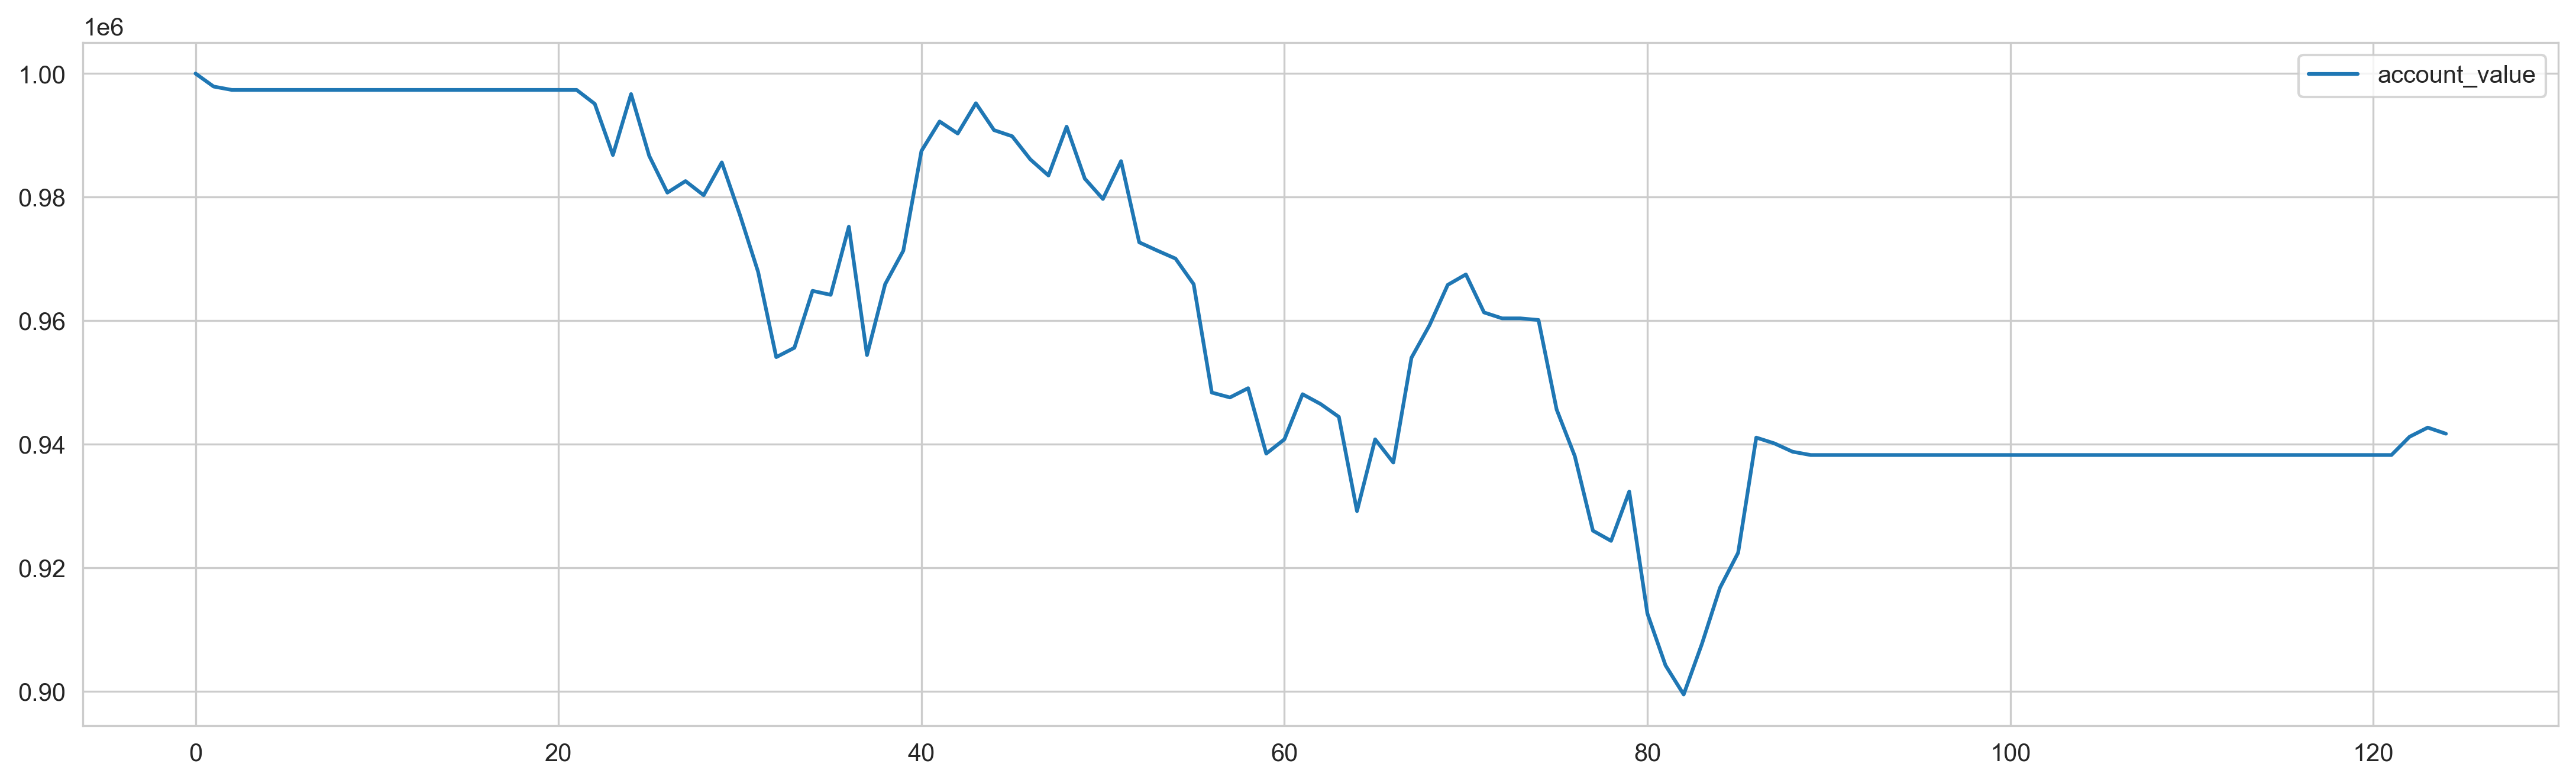

In [75]:
account_memory.plot()

In [76]:
actions_memory['MSFT'].value_counts()

MSFT
0    124
Name: count, dtype: int64

<Axes: xlabel='date'>

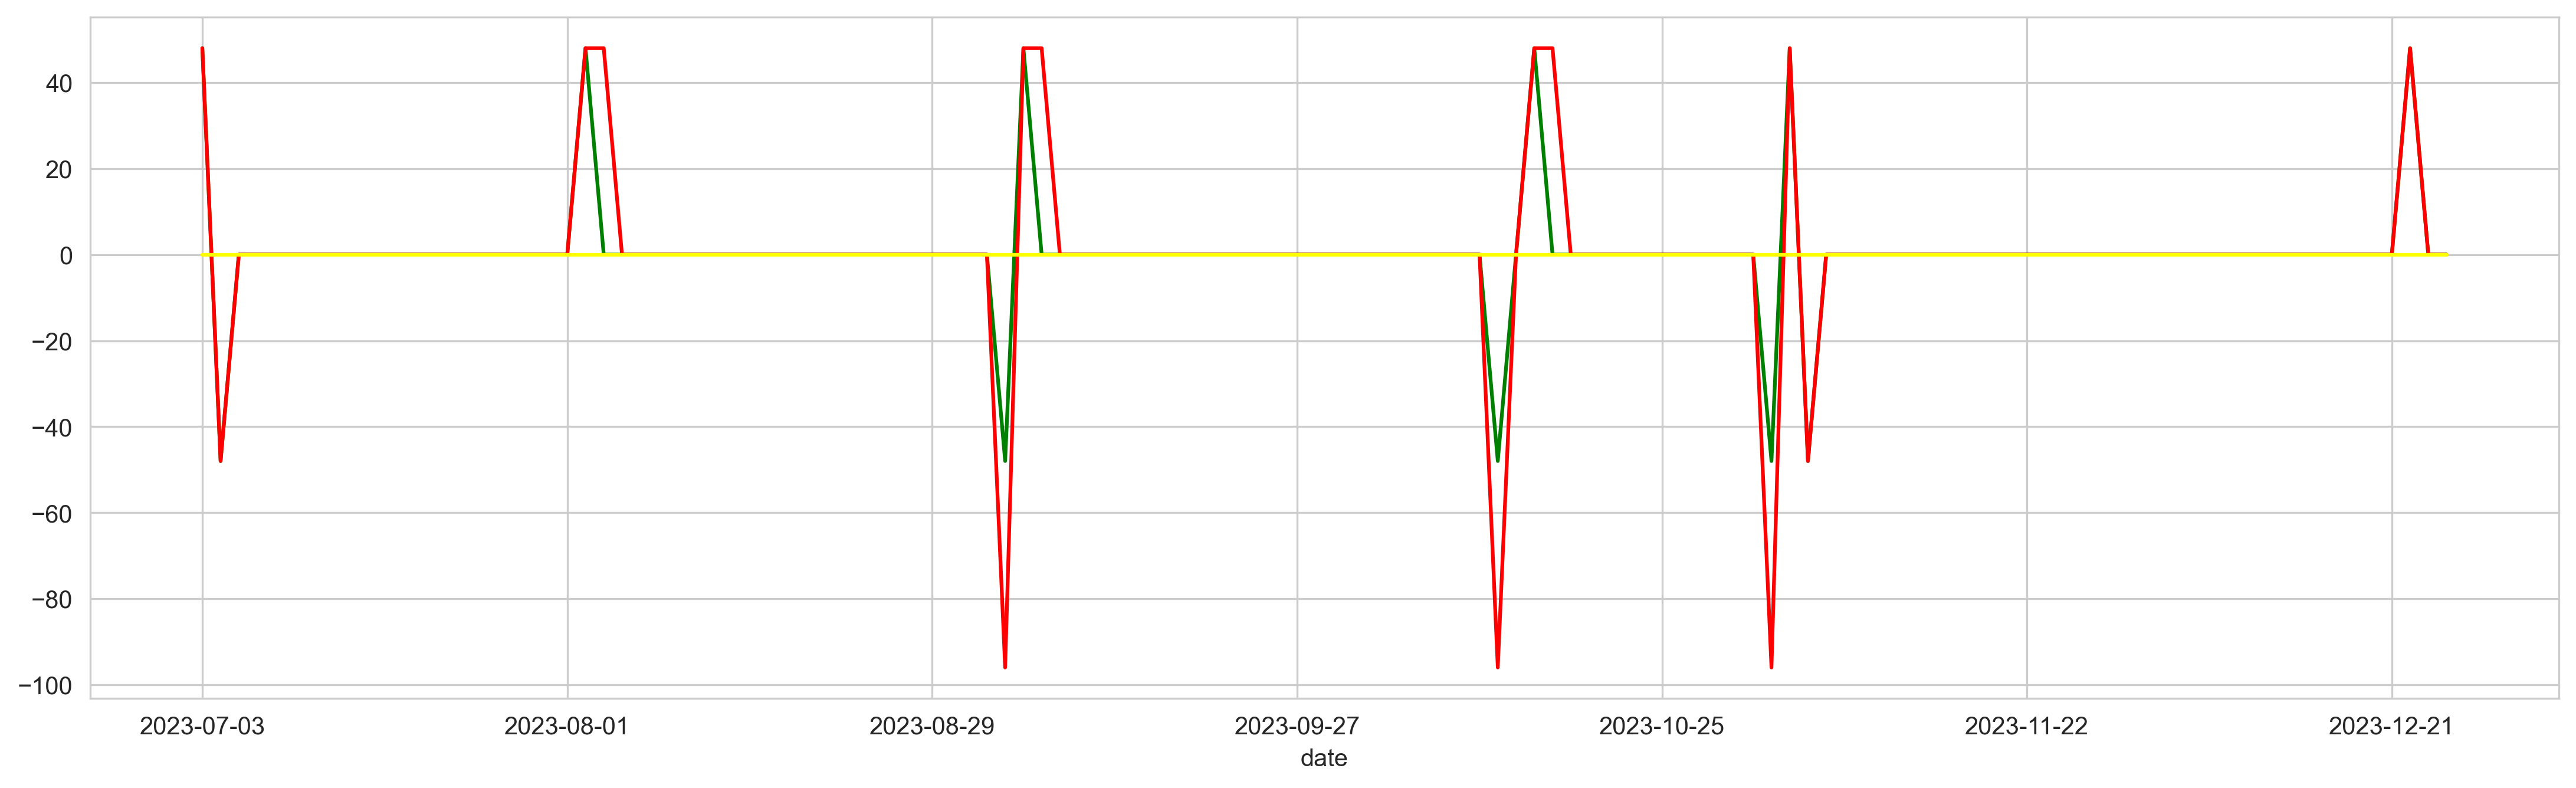

In [80]:
actions_memory['NFLX'].plot(color='green')
actions_memory['AAPL'].plot(color='red')
# actions_memory['AMZN'].plot(color='blue')
actions_memory['MSFT'].plot(color='yellow')

<Axes: >

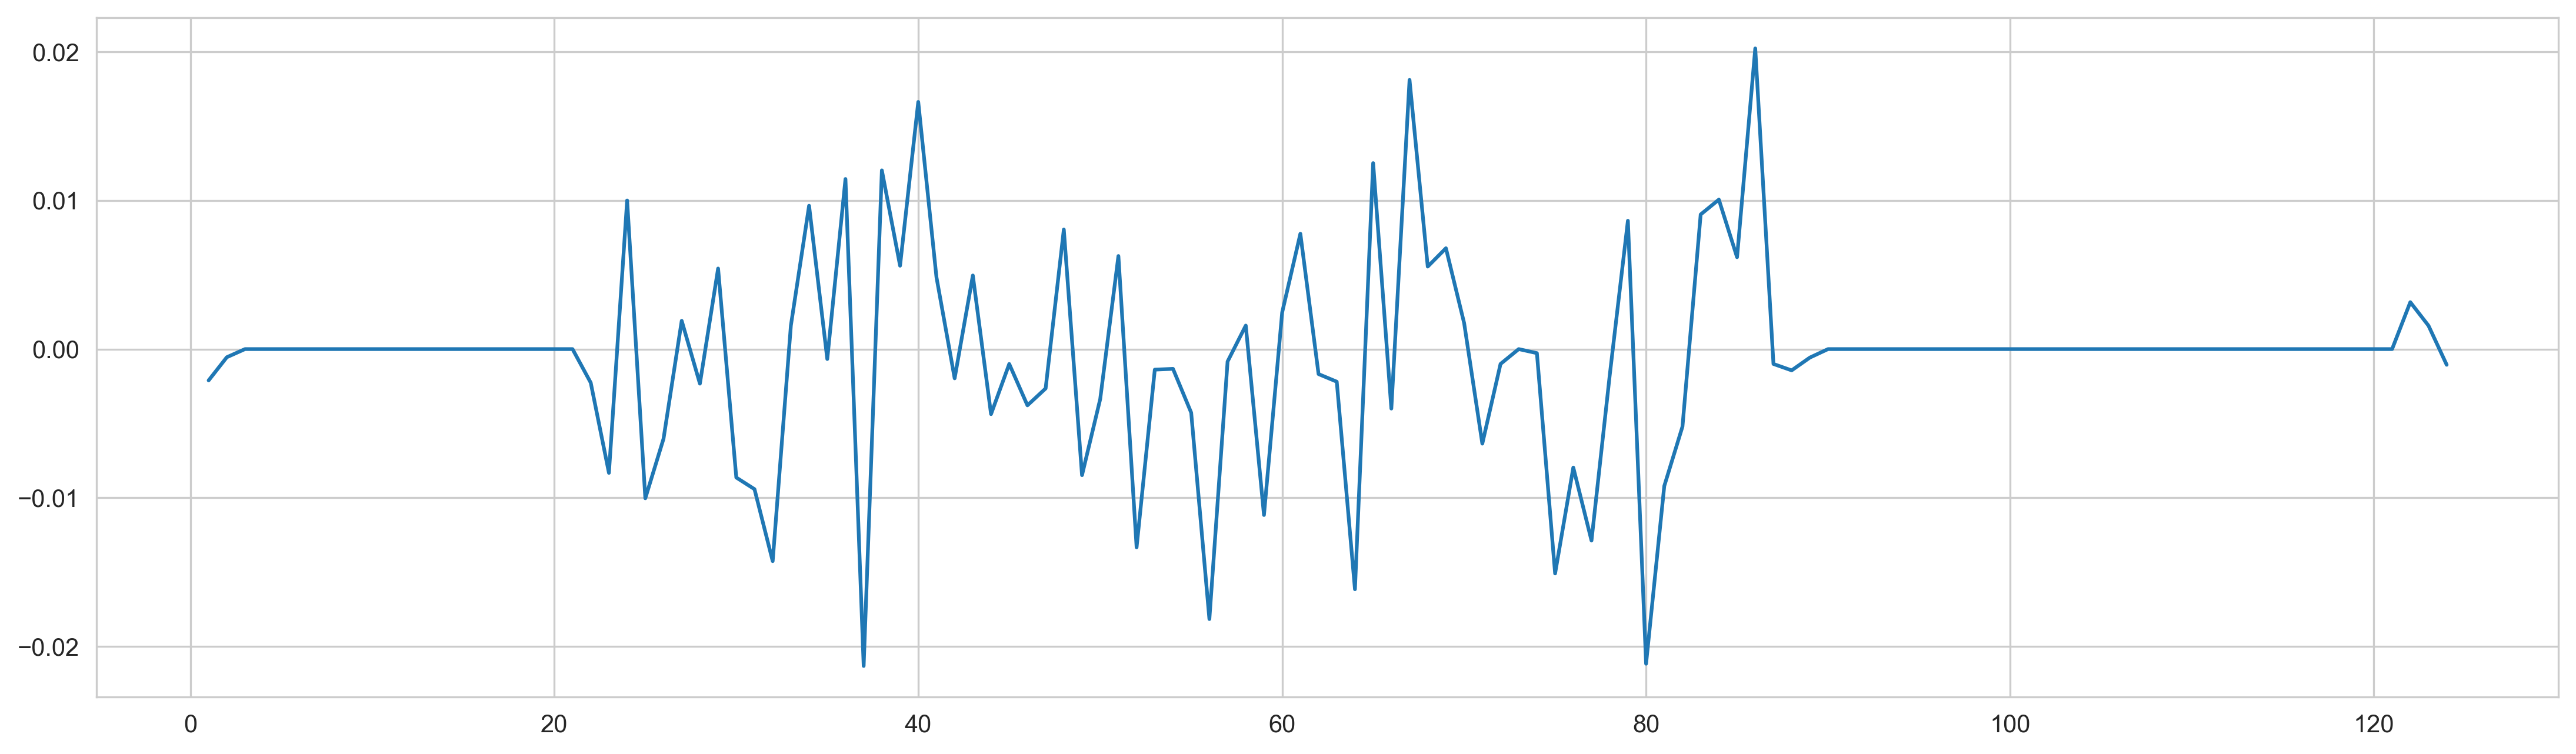

In [78]:
account_memory['account_value'].pct_change().plot()

In [79]:
cdfghfh

NameError: name 'cdfghfh' is not defined

TypeError: unsupported operand type(s) for /: 'Axes' and 'int'

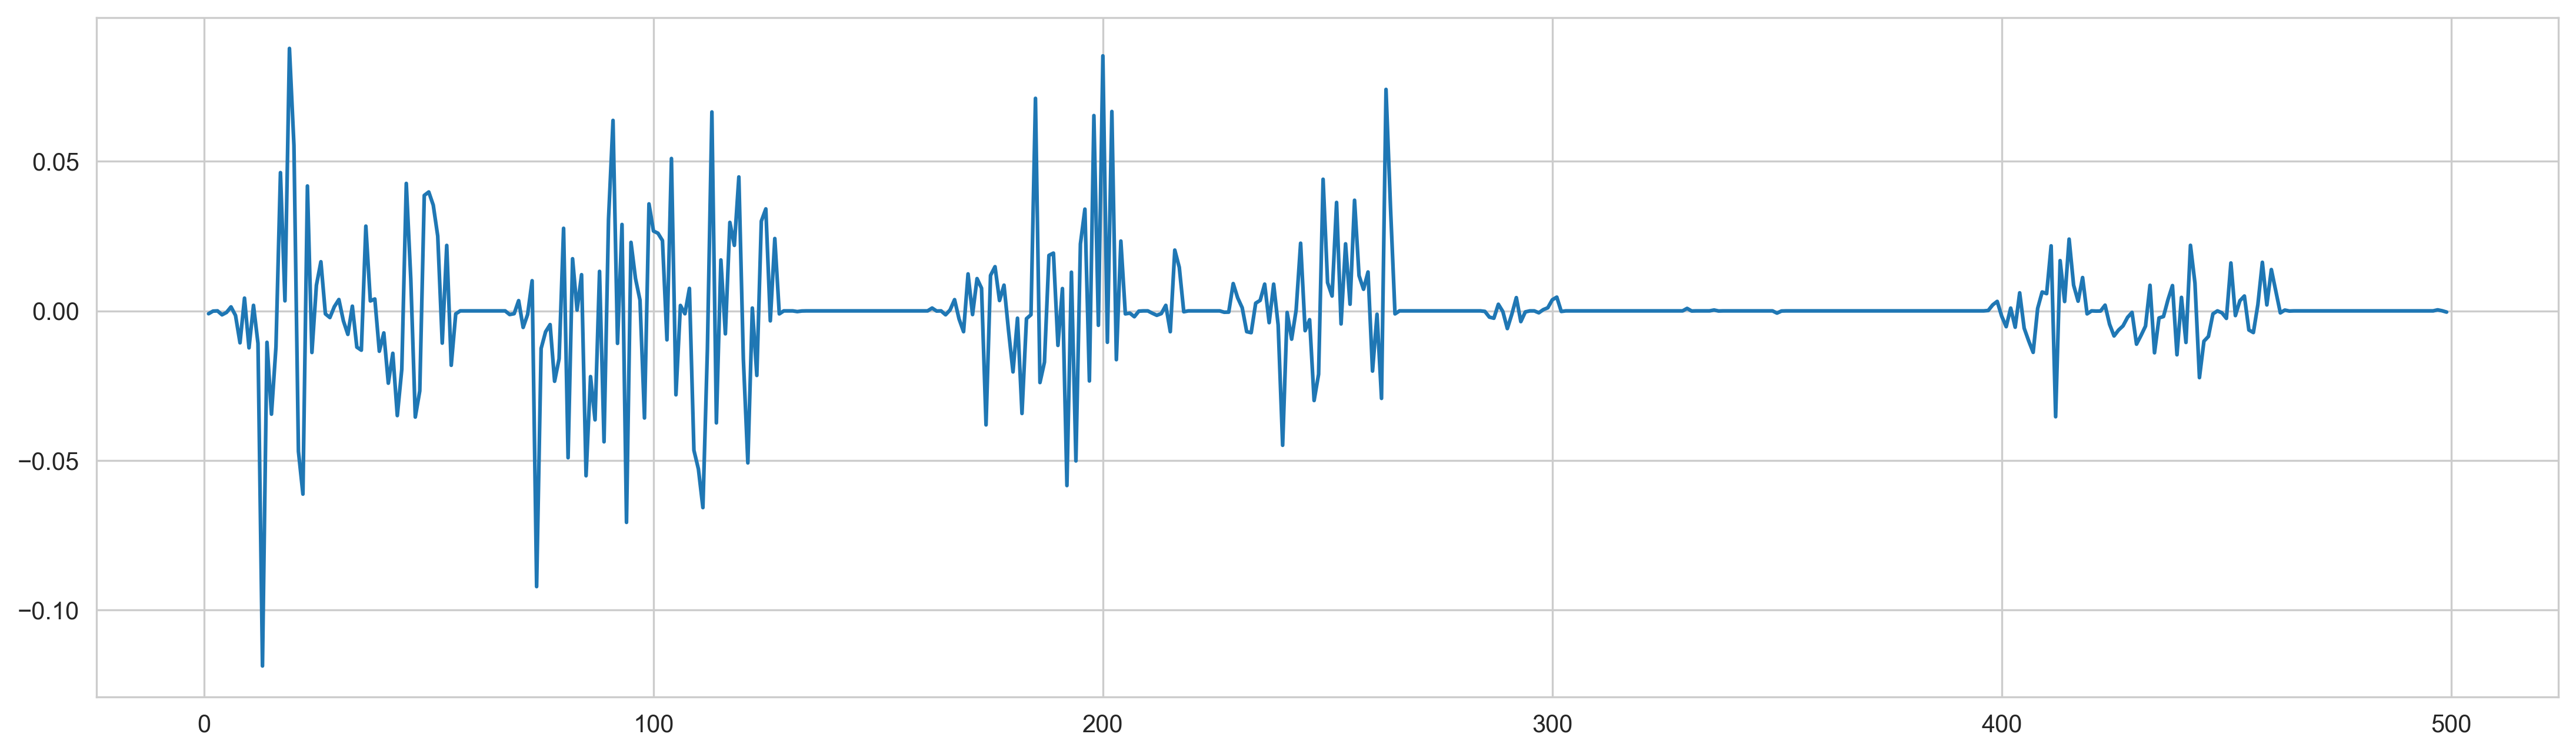

In [ ]:

# Calculate daily returns
daily_returns = account_memory['account_value'].pct_change().plot()

# Sharpe Ratio
risk_free_rate = 0.0  # Assuming risk-free rate is 0 for simplicity
mean_return = np.mean(daily_returns)
std_return = np.std(daily_returns)
sharpe_ratio = (mean_return - risk_free_rate) / std_return
print(f"Sharpe Ratio: {sharpe_ratio}")

# Maximum Drawdown
max_drawdown = (account_memory['account_value'].cummax() - account_memory['account_value']).min()
print(f"Maximum Drawdown: {max_drawdown}")

# Sortino Ratio
negative_returns = daily_returns[daily_returns < 0]
sortino_ratio = mean_return / np.std(negative_returns)
print(f"Sortino Ratio: {sortino_ratio}")


In [ ]:
actions_memory['actions'].value_counts()

KeyError: 'actions'

In [ ]:
from typing import Dict, List, Union, Any, NamedTuple
import torch as th
a = Union[List[list], Dict[str, Any]]
a = 5.5
print(a)

5.5


In [ ]:
# Results metrics: ????
# Draw down
# eqal 
# Sharpe ratio
# Max drawdown
# Return 

## End

----


In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("processed_daily_v2.csv")

data.head(10)

,date,tic,open,high,low,close,noOfTrans,volume,volumeWeight,weekday,...,open_sma_sdelta,open_sma_sbuzz,open_sma_sdispersion,open_sma_smean,close_sma_sscore,close_sma_svolume,close_sma_sdelta,close_sma_sbuzz,close_sma_sdispersion,close_sma_smean
0,2019-01-02,AAPL,38.7225,39.7125,38.5575,39.4800,249129.0,148159000.0,38.8871,2,...,-0.110,0.454,0.487,-3.457,-0.154,681.0,-0.210,0.792,0.439,-3.440
1,2019-01-03,AAPL,35.9950,36.4300,35.5000,35.5475,663513.0,365249000.0,35.8950,3,...,0.002,4.914,0.419,-6.359,-4.049,8786.0,0.015,3.263,0.409,-7.651
2,2019-01-04,AAPL,36.1325,37.1375,35.9500,37.0650,376070.0,234284000.0,36.7049,4,...,0.020,2.746,0.363,-8.173,-0.931,4299.0,-0.005,2.021,0.393,-7.671
3,2019-01-07,AAPL,37.1750,37.2075,36.4750,36.9825,348120.0,219111000.0,36.8423,0,...,-0.012,0.766,0.511,-7.485,0.432,493.0,0.003,0.758,0.529,-7.433
4,2019-01-08,AAPL,37.3900,37.9550,37.1300,37.6875,272197.0,164101000.0,37.5382,1,...,-0.002,1.320,0.474,-7.570,0.018,1328.0,0.058,0.636,0.408,-7.655
5,2019-01-09,AAPL,37.8225,38.6325,37.4075,38.3275,302931.0,180396000.0,38.2344,2,...,0.012,0.701,0.384,-7.413,0.222,1811.0,-0.055,0.776,0.367,-7.377
6,2019-01-10,AAPL,38.1250,38.4925,37.7150,38.4500,202210.0,143123000.0,38.1879,3,...,0.007,0.686,0.384,-7.470,-0.073,1246.0,0.031,0.597,0.422,-7.449
7,2019-01-11,AAPL,38.2200,38.4250,37.8775,38.0725,174588.0,108083000.0,38.0991,4,...,0.003,0.556,0.453,-7.245,0.500,1048.0,0.024,0.577,0.509,-7.067
8,2019-01-14,AAPL,37.7125,37.8175,37.3050,37.5000,201651.0,129757000.0,37.5041,0,...,0.000,0.693,0.607,-6.523,0.236,480.0,-0.070,0.675,0.577,-6.537
9,2019-01-15,AAPL,37.5675,38.3475,37.5125,38.2675,178869.0,114841000.0,38.0894,1,...,-0.004,0.825,0.471,-6.516,0.332,836.0,0.041,0.579,0.465,-6.435


In [ ]:
data.columns

Index(['date', 'tic', 'open', 'high', 'low', 'close', 'noOfTrans', 'volume',
       'volumeWeight', 'weekday', 'day', 'year', 'month', 'open_sma_sscore',
       'open_sma_svolume', 'open_sma_sdelta', 'open_sma_sbuzz',
       'open_sma_sdispersion', 'open_sma_smean', 'close_sma_sscore',
       'close_sma_svolume', 'close_sma_sdelta', 'close_sma_sbuzz',
       'close_sma_sdispersion', 'close_sma_smean'],
      dtype='object')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib import rcParams
import scipy
from scipy.stats import skew, kurtosis

rcParams["figure.figsize"] = 18, 5
sns.set_style('whitegrid')

In [ ]:
apple = data[data.tic == 'AAPL']

In [ ]:
apple

,date,tic,open,high,low,close,noOfTrans,volume,volumeWeight,weekday,...,open_sma_sdelta,open_sma_sbuzz,open_sma_sdispersion,open_sma_smean,close_sma_sscore,close_sma_svolume,close_sma_sdelta,close_sma_sbuzz,close_sma_sdispersion,close_sma_smean
0,2019-01-02,AAPL,38.7225,39.7125,38.5575,39.4800,249129.0,148159000.0,38.8871,2,...,-0.1100,0.4540,0.487,-3.4570,-0.1540,681.0,-0.2100,0.7920,0.439,-3.4400
1,2019-01-03,AAPL,35.9950,36.4300,35.5000,35.5475,663513.0,365249000.0,35.8950,3,...,0.0020,4.9140,0.419,-6.3590,-4.0490,8786.0,0.0150,3.2630,0.409,-7.6510
2,2019-01-04,AAPL,36.1325,37.1375,35.9500,37.0650,376070.0,234284000.0,36.7049,4,...,0.0200,2.7460,0.363,-8.1730,-0.9310,4299.0,-0.0050,2.0210,0.393,-7.6710
3,2019-01-07,AAPL,37.1750,37.2075,36.4750,36.9825,348120.0,219111000.0,36.8423,0,...,-0.0120,0.7660,0.511,-7.4850,0.4320,493.0,0.0030,0.7580,0.529,-7.4330
4,2019-01-08,AAPL,37.3900,37.9550,37.1300,37.6875,272197.0,164101000.0,37.5382,1,...,-0.0020,1.3200,0.474,-7.5700,0.0180,1328.0,0.0580,0.6360,0.408,-7.6550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126164,2023-12-22,AAPL,195.1800,195.4100,192.9700,193.6000,500544.0,37149600.0,194.1010,4,...,-0.4032,1.4160,0.664,0.7132,1.5044,213.0,-0.0034,1.0505,0.690,0.7545
126165,2023-12-26,AAPL,193.6100,193.8900,192.8300,193.0500,488257.0,28919300.0,193.1710,1,...,-0.0795,1.8298,0.583,0.6101,3.0791,437.0,-0.1365,2.5410,0.661,0.7083
126166,2023-12-27,AAPL,192.4900,193.5000,191.0900,193.1500,548076.0,48087700.0,192.5680,2,...,0.0569,2.6101,0.644,0.7168,2.4381,370.0,0.3046,1.9974,0.638,0.6875
126167,2023-12-28,AAPL,194.1400,194.6600,193.1700,193.5800,472404.0,34049900.0,193.9220,3,...,-0.2158,1.4245,0.651,0.7046,1.3867,239.0,-0.0970,1.2777,0.711,0.7546


In [ ]:
len(data)

128189

In [ ]:
data.year.value_counts()

year
2020    25806
2021    25704
2022    25602
2023    25602
2019    25475
Name: count, dtype: int64

In [ ]:
data.weekday.value_counts()

weekday
1    26373
2    26370
3    25963
4    25657
0    23826
Name: count, dtype: int64

In [ ]:
apple.head(10)

,date,tic,open,high,low,close,noOfTrans,volume,volumeWeight,weekday,...,open_sma_sdelta,open_sma_sbuzz,open_sma_sdispersion,open_sma_smean,close_sma_sscore,close_sma_svolume,close_sma_sdelta,close_sma_sbuzz,close_sma_sdispersion,close_sma_smean
0,2019-01-02,AAPL,38.7225,39.7125,38.5575,39.4800,249129.0,148159000.0,38.8871,2,...,-0.110,0.454,0.487,-3.457,-0.154,681.0,-0.210,0.792,0.439,-3.440
1,2019-01-03,AAPL,35.9950,36.4300,35.5000,35.5475,663513.0,365249000.0,35.8950,3,...,0.002,4.914,0.419,-6.359,-4.049,8786.0,0.015,3.263,0.409,-7.651
2,2019-01-04,AAPL,36.1325,37.1375,35.9500,37.0650,376070.0,234284000.0,36.7049,4,...,0.020,2.746,0.363,-8.173,-0.931,4299.0,-0.005,2.021,0.393,-7.671
3,2019-01-07,AAPL,37.1750,37.2075,36.4750,36.9825,348120.0,219111000.0,36.8423,0,...,-0.012,0.766,0.511,-7.485,0.432,493.0,0.003,0.758,0.529,-7.433
4,2019-01-08,AAPL,37.3900,37.9550,37.1300,37.6875,272197.0,164101000.0,37.5382,1,...,-0.002,1.320,0.474,-7.570,0.018,1328.0,0.058,0.636,0.408,-7.655
5,2019-01-09,AAPL,37.8225,38.6325,37.4075,38.3275,302931.0,180396000.0,38.2344,2,...,0.012,0.701,0.384,-7.413,0.222,1811.0,-0.055,0.776,0.367,-7.377
6,2019-01-10,AAPL,38.1250,38.4925,37.7150,38.4500,202210.0,143123000.0,38.1879,3,...,0.007,0.686,0.384,-7.470,-0.073,1246.0,0.031,0.597,0.422,-7.449
7,2019-01-11,AAPL,38.2200,38.4250,37.8775,38.0725,174588.0,108083000.0,38.0991,4,...,0.003,0.556,0.453,-7.245,0.500,1048.0,0.024,0.577,0.509,-7.067
8,2019-01-14,AAPL,37.7125,37.8175,37.3050,37.5000,201651.0,129757000.0,37.5041,0,...,0.000,0.693,0.607,-6.523,0.236,480.0,-0.070,0.675,0.577,-6.537
9,2019-01-15,AAPL,37.5675,38.3475,37.5125,38.2675,178869.0,114841000.0,38.0894,1,...,-0.004,0.825,0.471,-6.516,0.332,836.0,0.041,0.579,0.465,-6.435


In [ ]:
data.day.unique()

array([ 2,  3,  4,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18, 22, 23, 24, 25,
       28, 29, 30, 31,  1,  5,  6, 12, 13, 19, 20, 21, 26, 27,  0],
      dtype=int64)

In [ ]:
apple.index

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
       126159, 126160, 126161, 126162, 126163, 126164, 126165, 126166, 126167,
       126168],
      dtype='int64', length=1259)

In [ ]:
len(data.tic.unique())

102

In [ ]:
apple.weekday.unique()

array([2, 3, 4, 0, 1], dtype=int64)

In [ ]:
apple[apple.weekday == 19]

,date,tic,open,high,low,close,noOfTrans,volume,volumeWeight,weekday,...,open_sma_sdelta,open_sma_sbuzz,open_sma_sdispersion,open_sma_smean,close_sma_sscore,close_sma_svolume,close_sma_sdelta,close_sma_sbuzz,close_sma_sdispersion,close_sma_smean


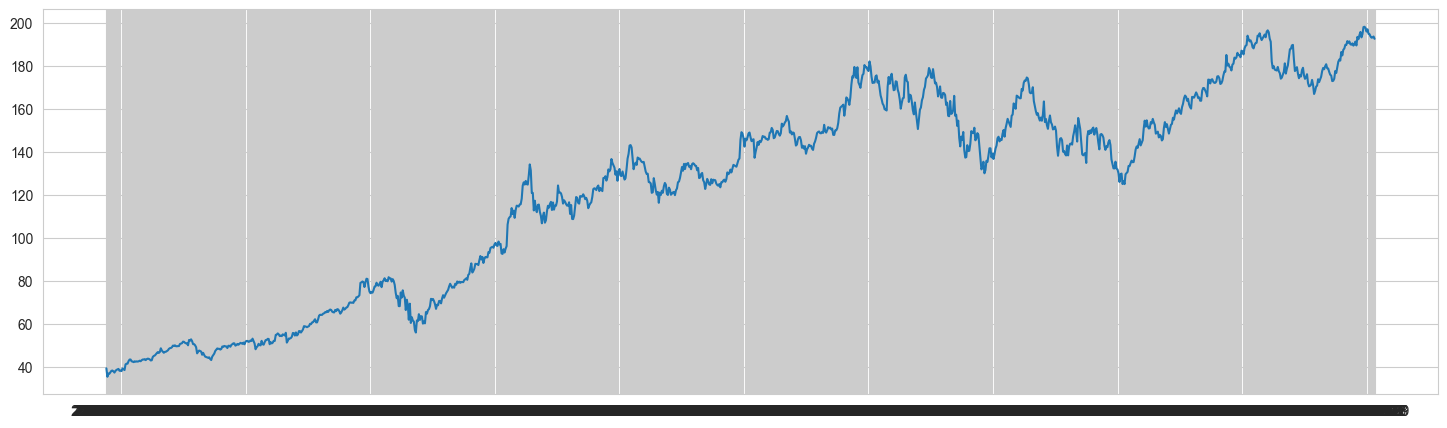

In [ ]:
# plt.plot(apple.date, apple.noOfTrans)
plt.plot(apple.date, apple.close)

In [ ]:
data.tic.unique()[1]

'ADBE'

In [ ]:
data[data.tic == data.tic.unique()[1]]

,date,tic,open,high,low,close,noOfTrans,volume,volumeWeight,weekday,...,open_sma_sdelta,open_sma_sbuzz,open_sma_sdispersion,open_sma_smean,close_sma_sscore,close_sma_svolume,close_sma_sdelta,close_sma_sbuzz,close_sma_sdispersion,close_sma_smean
21,2019-01-02,ADBE,219.91,226.17,219.00,224.57,33560.0,2784110.0,223.604,2,...,0.001,0.634,0.800,-0.334,0.228,12.0,-0.002,0.785,0.917,-0.292
22,2019-01-03,ADBE,220.88,223.63,215.15,215.70,43678.0,3654510.0,217.173,3,...,-0.005,1.150,0.833,-0.049,-1.067,30.0,0.008,0.577,0.867,0.018
23,2019-01-04,ADBE,219.84,227.65,217.48,226.19,44626.0,4043380.0,225.272,4,...,-0.003,0.494,0.882,0.060,-0.178,19.0,-0.001,0.472,0.790,0.065
24,2019-01-07,ADBE,229.95,232.60,227.29,229.26,39774.0,3638530.0,229.964,0,...,-0.014,0.659,0.769,0.114,1.694,19.0,-0.019,1.165,0.842,0.133
25,2019-01-08,ADBE,232.65,233.77,228.33,232.68,40772.0,3685900.0,231.817,1,...,-0.017,1.422,0.870,0.142,0.497,22.0,-0.010,0.624,0.818,0.134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126184,2023-12-22,ADBE,600.80,601.86,596.00,598.75,57241.0,1660630.0,598.628,4,...,-0.003,0.538,0.643,0.307,-0.355,14.0,-0.004,0.561,0.714,0.305
126185,2023-12-26,ADBE,598.92,601.69,596.50,598.26,41794.0,1595050.0,598.162,1,...,-0.001,0.858,1.000,0.318,-0.995,5.0,0.003,0.775,1.000,0.310
126186,2023-12-27,ADBE,598.60,599.79,593.71,596.08,48023.0,1394900.0,595.904,2,...,0.000,1.193,0.625,0.314,-0.655,29.0,-0.020,0.646,0.724,0.314
126187,2023-12-28,ADBE,597.44,599.04,593.63,595.52,50952.0,1702550.0,595.753,3,...,0.002,0.614,0.857,0.293,-0.533,14.0,0.006,0.580,0.786,0.292


In [ ]:
data.columns

Index(['date', 'tic', 'open', 'high', 'low', 'close', 'noOfTrans', 'volume',
       'volumeWeight', 'weekday', 'day', 'year', 'month', 'open_sma_sscore',
       'open_sma_svolume', 'open_sma_sdelta', 'open_sma_sbuzz',
       'open_sma_sdispersion', 'open_sma_smean', 'close_sma_sscore',
       'close_sma_svolume', 'close_sma_sdelta', 'close_sma_sbuzz',
       'close_sma_sdispersion', 'close_sma_smean'],
      dtype='object')

In [ ]:
data.tic.unique()[2]

'ADI'

In [ ]:
data[data.tic == data.tic.unique()[2]].date.loc["2022-01-01":]

21333     2019-11-06
21334     2019-11-07
21335     2019-11-08
21336     2019-11-11
21337     2019-11-12
             ...    
126204    2023-12-22
126205    2023-12-26
126206    2023-12-27
126207    2023-12-28
126208    2023-12-29
Name: date, Length: 1048, dtype: object

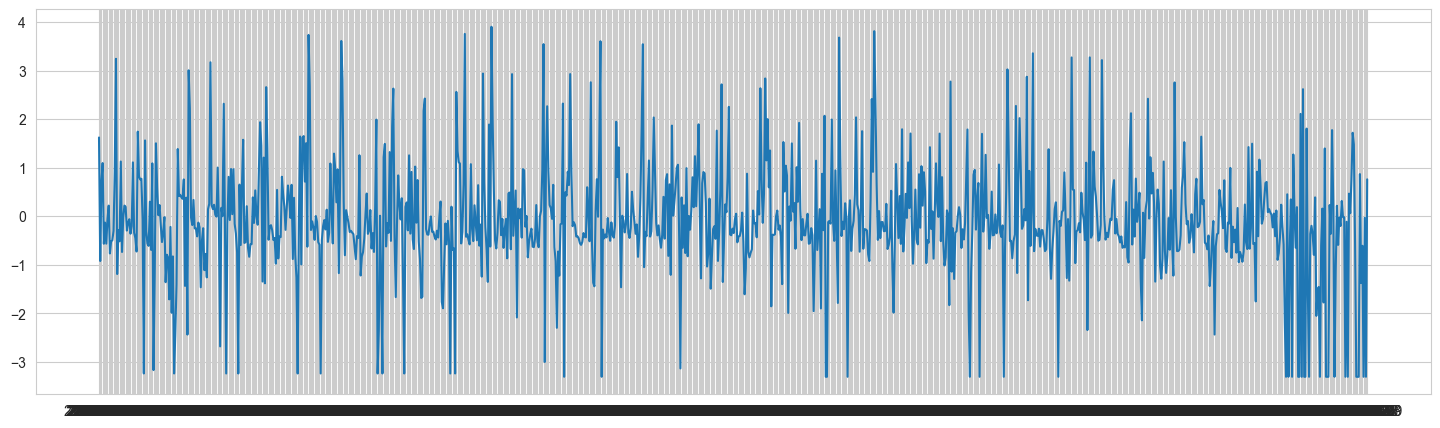

In [ ]:
plt.plot(data[data.tic == data.tic.unique()[2]].date.loc['2023-08-01':], data[data.tic == data.tic.unique()[2]].open_sma_sscore.loc['2023-08-01':])

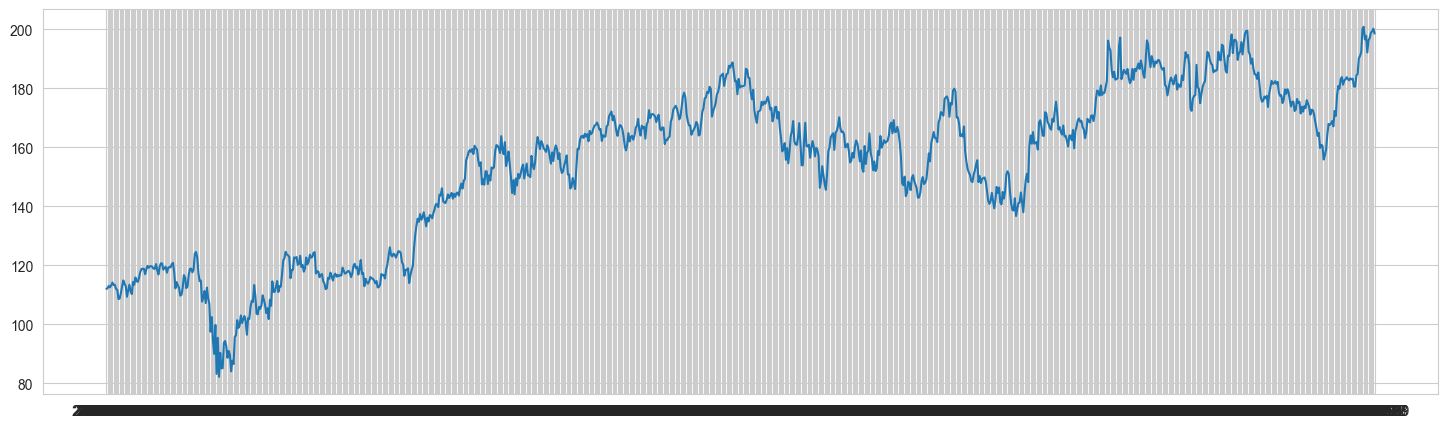

In [ ]:
plt.plot(data[data.tic == data.tic.unique()[2]].date.loc['2023-08-01':], data[data.tic == data.tic.unique()[2]].close.loc['2023-08-01':])

<Axes: xlabel='open_sma_sscore', ylabel='Count'>

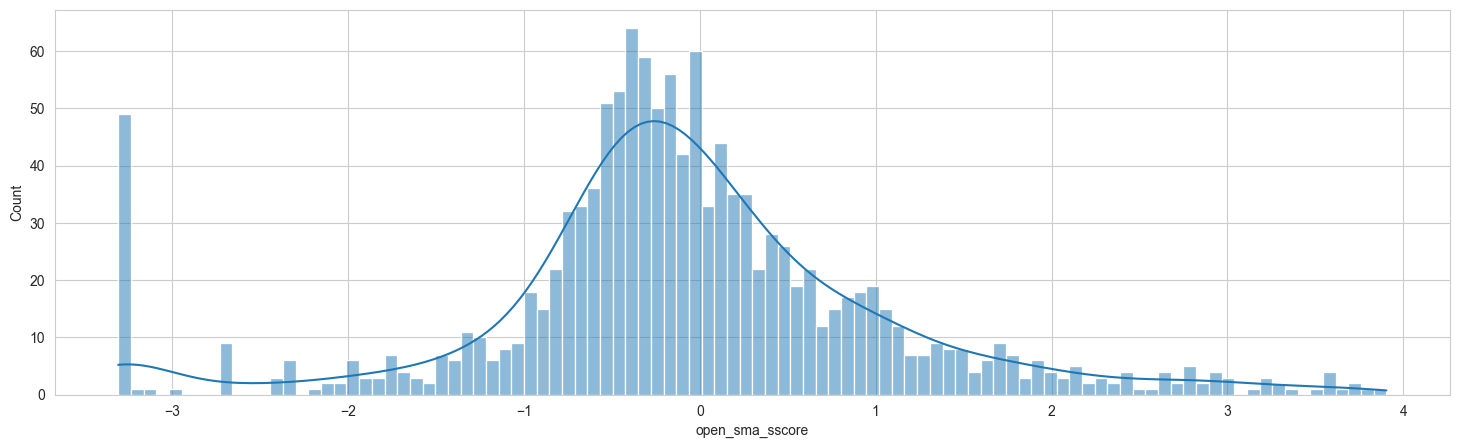

In [ ]:
sns.histplot(data[data.tic == data.tic.unique()[2]].open_sma_sscore, kde=True, bins=100)

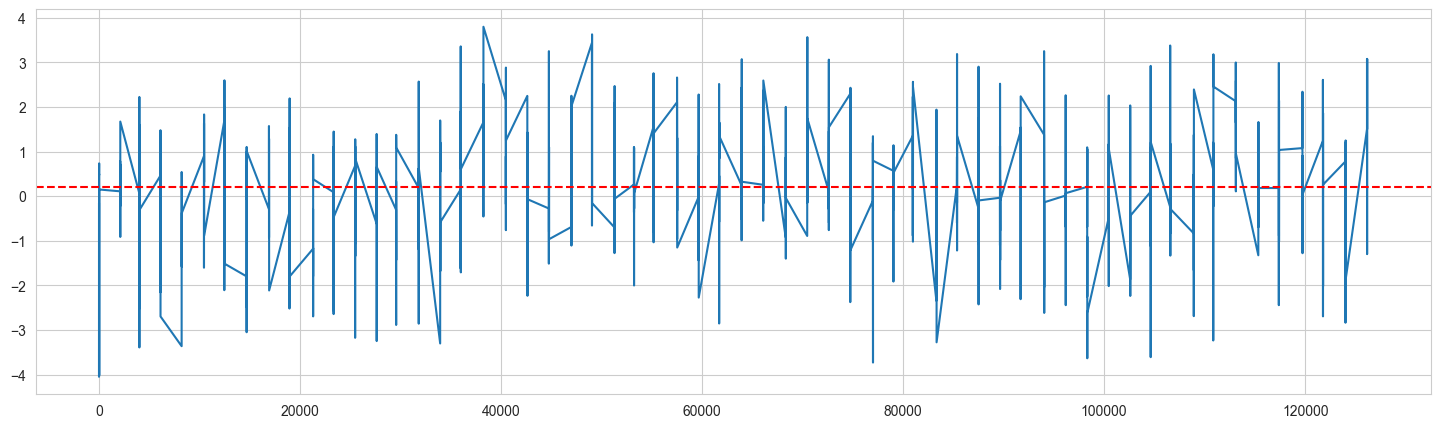

In [ ]:
apple.close_sma_sscore.plot()
plt.axhline(y=apple.close_sma_sscore.mean(), linestyle='--', color='r')

In [ ]:
import stable_baselines3

In [ ]:
for model_ in dir(stable_baselines3):
    if model_  is not None and not model_.startswith('_'):
        print(model_)


A2C
DDPG
DQN
HER
HerReplayBuffer
PPO
SAC
TD3
a2c
common
ddpg
dqn
file_handler
get_system_info
her
os
ppo
sac
td3
version_file


NameError: name 'train' is not defined

In [ ]:
from binance import client

binance = client.Client()

data = binance.get_historical_klines(symbol='BTCUSDT', interval='30m', start_str='2023-01-01', end_str='2024-01-02')

In [ ]:
len(data)

17567

In [ ]:
btc = pd.DataFrame(data, columns=['date', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
btc['date'] = pd.to_datetime(btc['date'], unit='ms')
btc.insert(1, 'tic', 'BTC/USDT')
btc['day'] = btc['date'].dt.dayofweek
btc['hour'] = btc['date'].dt.hour
btc = btc[['date', 'tic', 'open', 'high', 'low', 'close', 'volume', 'day', 'hour']]
columns = ['open', 'high', 'low', 'close', 'volume']
for col in columns:
    btc[col] = btc[col].astype(float)

In [ ]:
btc

,date,tic,open,high,low,close,volume,day,hour
0,2023-01-01 00:00:00,BTC/USDT,16541.77,16545.70,16517.72,16544.19,2275.16723,6,0
1,2023-01-01 00:30:00,BTC/USDT,16544.19,16544.61,16508.39,16529.67,2089.66847,6,0
2,2023-01-01 01:00:00,BTC/USDT,16529.59,16541.80,16525.78,16534.60,1638.93201,6,1
3,2023-01-01 01:30:00,BTC/USDT,16534.02,16556.80,16530.62,16551.47,1951.13468,6,1
4,2023-01-01 02:00:00,BTC/USDT,16551.47,16555.00,16539.57,16552.89,1707.51457,6,2
...,...,...,...,...,...,...,...,...,...
17562,2024-01-01 22:00:00,BTC/USDT,43619.22,43661.10,43361.60,43471.10,702.60096,0,22
17563,2024-01-01 22:30:00,BTC/USDT,43471.11,43531.49,43439.17,43529.93,321.76276,0,22
17564,2024-01-01 23:00:00,BTC/USDT,43529.94,44000.00,43529.93,43989.99,1762.46222,0,23
17565,2024-01-01 23:30:00,BTC/USDT,43989.99,44184.10,43929.75,44179.55,1713.50829,0,23


In [ ]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17567 entries, 0 to 17566
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    17567 non-null  datetime64[ns]
 1   tic     17567 non-null  object        
 2   open    17567 non-null  float64       
 3   high    17567 non-null  float64       
 4   low     17567 non-null  float64       
 5   close   17567 non-null  float64       
 6   volume  17567 non-null  float64       
 7   day     17567 non-null  int32         
 8   hour    17567 non-null  int32         
dtypes: datetime64[ns](1), float64(5), int32(2), object(1)
memory usage: 1.1+ MB


### If  we working on Hourly data, we need to convert all the data into same tz

- pandas has `tzinfo` function and `tzconvert('america/New York')`
- yfinace provides the `VIX` dat from 24 hours and we need to convert it
    - However `VIX` report at 9:00 to 10:00, instead `9:30` like so we need to resample 

In [ ]:
fe = FeatureEngineer(use_technical_indicator=True, tech_indicator_list=INDICATORS, use_vix=False, use_turbulence=True, user_defined_feature=False)

processed = fe.preprocess_data(btc)

processed

Successfully added technical indicators
Successfully added turbulence index


,date,tic,open,high,low,close,volume,day,hour,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2023-01-01 00:00:00,BTC/USDT,16541.77,16545.70,16517.72,16544.19,2275.16723,6,0,0.000000,16557.464381,16516.395619,0.000000,-66.666667,100.000000,16544.190000,16544.190000,0.000000
1,2023-01-01 00:30:00,BTC/USDT,16544.19,16544.61,16508.39,16529.67,2089.66847,6,0,-0.325769,16557.464381,16516.395619,0.000000,-66.666667,100.000000,16536.930000,16536.930000,0.000000
2,2023-01-01 01:00:00,BTC/USDT,16529.59,16541.80,16525.78,16534.60,1638.93201,6,1,-0.262216,16550.920491,16521.386176,25.993884,31.676040,100.000000,16536.153333,16536.153333,0.000000
3,2023-01-01 01:30:00,BTC/USDT,16534.02,16556.80,16530.62,16551.47,1951.13468,6,1,0.382201,16559.475565,16520.489435,61.458327,133.333333,29.505923,16539.982500,16539.982500,0.000000
4,2023-01-01 02:00:00,BTC/USDT,16551.47,16555.00,16539.57,16552.89,1707.51457,6,2,0.780826,16563.015590,16522.112410,63.002154,96.359392,29.505923,16542.564000,16542.564000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17562,2024-01-01 22:00:00,BTC/USDT,43619.22,43661.10,43361.60,43471.10,702.60096,0,22,273.739447,43876.566458,42209.513542,65.648082,123.342429,41.531487,42901.197333,42687.457667,1.802129
17563,2024-01-01 22:30:00,BTC/USDT,43471.11,43531.49,43439.17,43529.93,321.76276,0,22,268.876950,43925.987546,42248.247454,66.555304,110.840845,41.531487,42935.779667,42703.082000,0.262874
17564,2024-01-01 23:00:00,BTC/USDT,43529.94,44000.00,43529.93,43989.99,1762.46222,0,23,298.703120,44061.506780,42240.000220,72.442868,155.517942,58.150338,42986.046000,42727.847667,16.719154
17565,2024-01-01 23:30:00,BTC/USDT,43989.99,44184.10,43929.75,44179.55,1713.50829,0,23,333.788773,44218.871080,42229.036920,74.366293,176.736237,62.613956,43040.364667,42753.903000,2.525029


In [ ]:
processed.date.min()

Timestamp('2023-01-01 00:00:00')

In [ ]:
processed.date.max()

Timestamp('2024-01-02 00:00:00')

In [ ]:
# split the data into train and trade 

train = data_split(processed, '2023-01-01','2023-08-31')
trade = data_split(processed, '2023-09-01', '2023-12-31')

In [ ]:
trade

,date,tic,open,high,low,close,volume,day,hour,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2023-09-01 00:00:00,BTC/USDT,25940.77,26034.97,25931.11,26028.72,706.77601,4,0,-280.529246,27075.746545,25519.332455,31.163178,-78.989982,69.010610,26601.057000,26921.458333,0.894114
1,2023-09-01 00:30:00,BTC/USDT,26028.72,26070.00,26017.41,26051.97,334.16483,4,0,-264.757948,26906.692948,25576.017052,32.005421,-68.559345,64.028781,26562.847000,26900.991500,0.060467
2,2023-09-01 01:00:00,BTC/USDT,26051.97,26057.90,25989.78,25997.84,644.87814,4,1,-253.702396,26703.180155,25664.847845,31.089274,-68.932534,64.901095,26522.561333,26880.343333,0.336702
3,2023-09-01 01:30:00,BTC/USDT,25997.84,26003.92,25974.13,25985.72,462.88879,4,1,-243.116281,26529.529805,25744.869195,30.884502,-69.311162,65.408995,26482.024333,26860.467333,0.016972
4,2023-09-01 02:00:00,BTC/USDT,25985.71,26052.75,25985.71,26047.93,508.26281,4,2,-227.089139,26387.355039,25820.247961,33.220037,-61.020593,57.793307,26440.273667,26840.105333,0.441975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,2023-12-30 21:30:00,BTC/USDT,42309.96,42322.08,42240.00,42305.08,344.60027,5,21,84.328917,42643.316755,41935.663245,51.971832,44.555919,0.831948,42124.775000,42066.209833,0.000011
5804,2023-12-30 22:00:00,BTC/USDT,42305.08,42308.69,42218.87,42265.83,291.64345,5,22,73.263727,42638.719279,41959.100721,51.083451,35.745899,1.462947,42133.205000,42067.105333,0.090474
5805,2023-12-30 22:30:00,BTC/USDT,42265.83,42265.84,42079.97,42132.73,310.74578,5,22,53.141841,42623.868098,41988.194902,48.193558,5.745114,15.049169,42139.390667,42069.796833,1.260505
5806,2023-12-30 23:00:00,BTC/USDT,42132.73,42295.61,42102.88,42242.01,405.13881,5,23,45.488718,42592.254862,42049.410138,50.568700,18.337119,11.526141,42152.616667,42076.311667,1.021103


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [ ]:
# enviornment and agent initalization 

env_kwargs = {
    "hmax": 1e1,
    "initial_amount": 1e6,
    "state_space": state_space,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "buy_cost_pct":[1e-3],
    "sell_cost_pct":[1e-3],
    "stock_dim": stock_dimension, 
    "num_stock_shares": [0],
    "tech_indicator_list": INDICATORS
}

e_train_gym = StockTradingEnv(df=processed, **env_kwargs)   


In [ ]:
env_train,_ = e_train_gym.get_sb_env()

In [ ]:
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [ ]:
# Agent initialization

agent = DRLAgent(env=env_train)
ddpg = agent.get_model("ddpg")


{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
if_using_ddpg = True
from stable_baselines3.common.logger import configure


if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  ddpg.set_logger(new_logger_ddpg)

Logging to results/ddpg


In [ ]:
trainded_model = agent.train_model(model=ddpg, tb_log_name="ddpg",total_timesteps=5000)

In [ ]:
trainded_model.get_parameters()

{'policy': OrderedDict([('actor.mu.0.weight',
               tensor([[ 0.1496,  0.0461, -0.0844,  ..., -0.1186, -0.1444, -0.1673],
                       [ 0.0141,  0.0060, -0.1260,  ..., -0.2472,  0.0722, -0.2182],
                       [-0.0642, -0.2666, -0.0196,  ...,  0.1546, -0.0494, -0.2085],
                       ...,
                       [-0.2514, -0.0568,  0.0485,  ...,  0.1078, -0.1743,  0.1697],
                       [-0.0574,  0.2499,  0.1527,  ..., -0.0406,  0.0809,  0.1163],
                       [-0.0264, -0.2840, -0.1836,  ..., -0.1851,  0.1628,  0.2192]])),
              ('actor.mu.0.bias',
               tensor([-0.0118, -0.0228,  0.2444,  0.0338, -0.1555, -0.0512, -0.1012, -0.1101,
                       -0.2726, -0.0310, -0.1273, -0.1826,  0.0909, -0.0321,  0.0137, -0.2625,
                       -0.1107,  0.2355, -0.1642, -0.2437, -0.0441, -0.0309,  0.2057,  0.0926,
                        0.2551,  0.2834,  0.0727,  0.0678, -0.2042,  0.0977,  0.2122, -0.1742,

In [ ]:
trainded_model.save(TRAINED_MODEL_DIR + "/agent_ddpg")


In [ ]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trainded_model, 
    environment = e_train_gym)

hit end!


In [ ]:
import torch as th

In [ ]:
lst = [[1,2,3],[4,5,6]]
a = th.tensor(lst)

In [ ]:
a

tensor([[1, 2, 3],
        [4, 5, 6]])

In [ ]:
b = th.tensor([2,4,5])

In [ ]:
a.shape

torch.Size([2, 3])

In [ ]:
bb = np.array([1,2,3])

In [ ]:
th.from_numpy(bb)

tensor([1, 2, 3], dtype=torch.int32)

In [ ]:
b.device

device(type='cpu')

In [ ]:
# to create the layer of network

import torch.nn as nn 

input_tensor = th.tensor([[0.3471, 0.4547, -0.2356]])

In [ ]:
from torchsummary import summary

In [ ]:
# define the first linear layer 

linear_layer = nn.Linear(in_features=3, out_features=2)
# pass input through linear layer 

output = linear_layer(input_tensor)

print(output)

tensor([[-0.5977, -0.2475]], grad_fn=<AddmmBackward0>)


In [ ]:
linear_layer.weight

Parameter containing:
tensor([[-0.2567, -0.0337,  0.1214],
        [-0.4081,  0.0641,  0.3577]], requires_grad=True)

In [ ]:
linear_layer.bias

Parameter containing:
tensor([-0.4646, -0.0507], requires_grad=True)

In [ ]:
# visualize the shape of the network 

import torch.nn as nn
import torch.nn.functional as F

input_tensor = th.tensor([[0.3471, 0.4547, -0.2356]])

# define the first linear layer (Hidden Layer) which perform the linear transformation
# linear transformation is a matrix multiplication in PyTorch (xW^T + b)
# y =Wo dot X + b (W = weight, b = bias)
# In pyTrouch: output = W @ input + b
linear_layer = nn.Linear(in_features=3, out_features=2)

output = linear_layer(input_tensor)

print(output)


tensor([[-0.4727, -0.3152]], grad_fn=<AddmmBackward0>)


In [ ]:
# Stacking Layers wiht nn.Sequential

model = nn.Sequential(
    nn.Linear(10, 18, device="cuda"),
    nn.Linear(18, 20, device="cuda"),
    nn.Linear(20, 5, device="cuda")
)

In [ ]:
print(model)

Sequential(
  (0): Linear(in_features=10, out_features=18, bias=True)
  (1): Linear(in_features=18, out_features=3, bias=True)
  (2): Softmax(dim=-1)
)


In [ ]:
input_tens = th.tensor([[10.0]])
sigmoid = nn.Sigmoid()
output = sigmoid(input_tens)
output

tensor([[1.0000]])

In [ ]:
model = nn.Sequential(
    nn.Linear(10,18),
    nn.Linear(18,3),
    nn.Softmax(dim=-1)
)

In [ ]:
i = th.tensor([[0.3471, 0.4547, -0.2356]])

softmax = nn.Softmax(dim=-1)

output = softmax(i)

print(output)

tensor([[0.3743, 0.4168, 0.2090]])


In [ ]:
# Multi-class classification: forward pass

input_tensor = th.tensor([[5.,6.,7.,8.,10.,6.]])

n_classes = 1
model = nn.Sequential(
    nn.Linear(6, 4),
    nn.Linear(4, n_classes),

)

output = model(input_tensor)

print(output)

tensor([[-2.0246]], grad_fn=<AddmmBackward0>)


In [ ]:
model.cuda()

Sequential(
  (0): Linear(in_features=6, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=3, bias=True)
  (2): Softmax(dim=-1)
)

In [ ]:
# Transforming labels with one-hot encoding
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

F.one_hot(th.tensor([2]), num_classes=3)

tensor([[0, 0, 1]])

In [ ]:
# Cross entropy loss function
# This is define as the negative log likelihood function (NLL)

scores = th.tensor([[-0.1211, 0.1059]])

one_hot = th.tensor([[1,0]])

criterion = CrossEntropyLoss()

criterion(scores.double(), one_hot.double())

tensor(0.8131, dtype=torch.float64)

In [ ]:
# Calculate the loss and compute the gradients

model = nn.Sequential(
    nn.Linear(6, 4),
    nn.Linear(4, 1),
)

prediction = model(th.tensor([[5.,6.,7.,8.,10.,6.]]))

target = th.tensor([[1.]])

criterion = CrossEntropyLoss()
loss = criterion(prediction, target)
loss.backward()

In [ ]:
model[0].weight.grad, model[0].bias.grad, 
model[1].weight.grad, model[0].bias.grad, 

(tensor([[0., 0., 0., 0.]]), tensor([0., 0., 0., 0.]))

In [ ]:
model[2].weight.grad, model[3].weight.bias

IndexError: index 2 is out of range

In [ ]:
F.one_hot(th.tensor([1]), num_classes=6)

tensor([[0, 1, 0, 0, 0, 0]])

In [ ]:
model = nn.Sequential(
    nn.Linear(6, 4),
    nn.Sigmoid(),
    nn.Linear(4, 1),
)

# input_tensor = th.tensor([[5.,6.,7.,8.,10.,6.]])
# target = th.tensor([[1.]])

# criterion = CrossEntropyLoss()

# loss = criterion(model(input_tensor), target)

# loss.backward()


bias_1 = model[0].bias
bias_1

Parameter containing:
tensor([-0.1926, -0.1285,  0.0910, -0.1679], requires_grad=True)

In [ ]:
from torch.optim import SGD

optimizer = SGD(model.parameters(), lr=0.01)

In [ ]:
model.parameters()

<generator object Module.parameters at 0x000001E37D23F3E0>

In [ ]:
prediction.shape

torch.Size([1, 1])

In [ ]:
model[1].weight.grad

tensor([[0., 0., 0., 0.]])

In [ ]:
prediction

tensor([[4.2546]], grad_fn=<AddmmBackward0>)

In [ ]:
import numpy as np 

In [ ]:
y_hat = np.array(10)
y = np.array(5)

mse_numpy = np.mean((y_hat - y)**2)
print(mse_numpy)

criterion = nn.MSELoss()

loss = criterion(th.from_numpy(y_hat).float(), th.from_numpy(y).float())
print(loss)

25.0
tensor(25.)


In [ ]:
th.from_numpy(np.array(10)).float()

tensor(10.)

In [ ]:
a = th.tensor(-3., requires_grad=True)
sigmoid = nn.ReLU()
sig_a = sigmoid(a)
sig_a.backward()
print(a.grad)

tensor(0.)


In [ ]:
model

Sequential(
  (0): Linear(in_features=6, out_features=4, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
total = 0
for param in model.parameters():
    total += param.numel()

print(total)

33


In [ ]:
for i in model.parameters():
    print(i)
    print(i.shape)
    print(i.numel())

Parameter containing:
tensor([[ 0.1560,  0.2364,  0.1364, -0.3870, -0.3484, -0.0324],
        [-0.2586, -0.0538, -0.0407,  0.3731, -0.3305,  0.0674],
        [-0.3397,  0.0683, -0.3547, -0.3529,  0.0687, -0.1934],
        [ 0.2892,  0.2219, -0.3952, -0.2368,  0.3457,  0.3069]],
       requires_grad=True)
torch.Size([4, 6])
24
Parameter containing:
tensor([-0.1926, -0.1285,  0.0910, -0.1679], requires_grad=True)
torch.Size([4])
4
Parameter containing:
tensor([[-0.0154, -0.3934,  0.2393, -0.4458]], requires_grad=True)
torch.Size([1, 4])
4
Parameter containing:
tensor([-0.4306], requires_grad=True)
torch.Size([1])
1


In [ ]:
n_features = 8
n_classes = 2

input_tensor = th.Tensor([[3, 4, 6, 2, 3, 6, 8, 9]])


layer = nn.Linear(60,124)

print(layer.weight.min(), layer.weight.max())

tensor(-0.1291, grad_fn=<MinBackward1>) tensor(0.1291, grad_fn=<MaxBackward1>)


In [ ]:
layer = nn.Linear(60,124)

nn.init.uniform_(layer.weight, -1, 1)
print(layer.fc.weight.min(), layer.fc.weight.max())

AttributeError: 'Linear' object has no attribute 'fc'

In [ ]:
for name, param in model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([4, 8])
0.bias torch.Size([4])
1.weight torch.Size([2, 4])
1.bias torch.Size([2])


In [ ]:
model = nn.Sequential(
    nn.Linear(6, 4),
    nn.Linear(4, 1),
    nn.Linear(1, 1)
)

In [ ]:
for name, param in model.named_parameters():
    if name == "0.weight":
        param.requires_grad = True

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

0.weight True
0.bias True
1.weight True
1.bias True
2.weight True
2.bias True


In [ ]:
nn.init.uniform_(model[0].weight)

Parameter containing:
tensor([[0.2608, 0.3630, 0.4184, 0.1973, 0.5893, 0.4510],
        [0.4110, 0.6233, 0.7035, 0.6622, 0.0605, 0.0972],
        [0.7638, 0.2822, 0.8504, 0.9445, 0.9875, 0.7192],
        [0.9680, 0.8399, 0.4306, 0.0507, 0.7573, 0.1863]], requires_grad=True)

In [ ]:

np.random.rand(12,8)


array([[0.41542602, 0.94073016, 0.07437289, 0.55082389, 0.17495564,
        0.35132458, 0.00298702, 0.04109842],
       [0.17324816, 0.84013504, 0.09167882, 0.27294052, 0.6842851 ,
        0.73070883, 0.94203453, 0.15738397],
       [0.01187941, 0.0032436 , 0.66051402, 0.06311534, 0.03701032,
        0.49203408, 0.12070017, 0.16955482],
       [0.11286445, 0.45469412, 0.46905046, 0.72432712, 0.53213514,
        0.92707148, 0.51765255, 0.72204163],
       [0.87760507, 0.35637478, 0.64620459, 0.87908656, 0.48456879,
        0.59994916, 0.1602203 , 0.16590042],
       [0.66881578, 0.93692315, 0.92382939, 0.95163567, 0.8609124 ,
        0.76874078, 0.69853911, 0.9264863 ],
       [0.76932992, 0.18437862, 0.08215028, 0.40294385, 0.52728283,
        0.45619383, 0.63584018, 0.05358361],
       [0.28299251, 0.88239954, 0.29794897, 0.64314762, 0.32448955,
        0.79061692, 0.52869067, 0.19894826],
       [0.63067199, 0.05435628, 0.50027573, 0.49413074, 0.89434895,
        0.80745943, 0.840432

In [ ]:
from torch.utils.data import DataLoader, Dataset, TensorDataset

dataset = Tenso

In [ ]:
np_features = np.array(np.random.rand(12, 8))
np_target = np.array(np.random.rand(12, 1))

In [ ]:
np_features

array([[0.6860231 , 0.41364125, 0.5897871 , 0.70748099, 0.19483778,
        0.21004053, 0.67672079, 0.09347895],
       [0.33938948, 0.39115276, 0.52020576, 0.94509669, 0.44117211,
        0.25032337, 0.52063888, 0.9686396 ],
       [0.64124662, 0.94568792, 0.01547889, 0.15990731, 0.68273673,
        0.99492353, 0.453152  , 0.22524696],
       [0.55633968, 0.77686346, 0.65291967, 0.79481708, 0.42051613,
        0.07763324, 0.2680586 , 0.17605518],
       [0.13272357, 0.60617782, 0.82321293, 0.94341339, 0.56698326,
        0.16377987, 0.4098448 , 0.68627203],
       [0.29114722, 0.93836483, 0.29786058, 0.22359134, 0.16273425,
        0.94719044, 0.74259109, 0.63781544],
       [0.58099555, 0.81062014, 0.45333711, 0.39647247, 0.10165431,
        0.98195118, 0.68800506, 0.79547634],
       [0.90504415, 0.48615845, 0.41061636, 0.75083131, 0.45961167,
        0.25167092, 0.68021304, 0.98700646],
       [0.908221  , 0.89826742, 0.02281646, 0.52686504, 0.66813896,
        0.61595696, 0.481531